In [1]:
import serial
import time
import random
random.seed(1)
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio

In [2]:
import serial_interface as si

### Environment Class

In [3]:
def load_and_prep_data(data_path):
    raw_df = pd.read_csv(data_path)
    data_df = raw_df.copy()
    # Make current positive
    data_df = data_df.drop_duplicates(subset=['motor_1_position','motor_2_position'])
    data_df['I_ivp_1'] = data_df['I_ivp_1'].abs()
    data_df['power'] = data_df['I_ivp_1'] * data_df['V_ivp_1']
    return data_df

In [4]:
def convert_motor_positions_to_index(position_tuple):
    # position tuple is (m1 position, m2 position)
    return (int(position_tuple[0]//5), int(position_tuple[1]//5))

def convert_index_to_motor_positions(index_tuple):
    return (index_tuple[0]*5, index_tuple[1]*5)

In [5]:
def arg_max_array_index(array):
    # Finds the argmax and randomly selects if multiple
    array_max = -10000
    max_list = []
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j] > array_max:
                array_max = array[i][j]
                max_list = [[i,j]]
            elif array[i][j] == array_max:
                max_list.append([i,j])
    if len(max_list) > 1:
        max_index = random.choice(max_list)
    else:
        max_index = max_list[0]
    return max_index

def random_array_index(array):
    x_index = range(array.shape[0])
    y_index = range(array.shape[1])
    return (random.choice(x_index), random.choice(y_index))

In [6]:
class SolarEnv:
    def __init__(self, reward_data_path, shape=(37,37)):
        self.shape = shape
        self.reward_array = np.zeros(shape)
        # load in reward data
        rewards = load_and_prep_data(reward_data_path)
        for index, row in rewards.iterrows():
            motor_1_index = int(row['motor_1_position'].item()//5)
            motor_2_index = int(row['motor_2_position'].item()//5)
            position_reward = row['power'].item()
            self.reward_array[motor_1_index][motor_2_index] = position_reward
    
    # For debugging
    def get_reward_array(self):
        return self.reward_array
    
    def get_env_shape(self):
        return self.reward_array.shape
                                          
    # Not needed right now
    def env_init(self):
        """
        Setup for the environment called when the experiment first starts.
        """
        pass
    
    # Not needed right now
    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """
        pass
    
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent, a tuple of motor positions

        Returns:
            (float, state): a tuple of the reward, state
        """
        index_tuples = convert_motor_positions_to_index(action)
        return self.reward_array[index_tuples[0]][index_tuples[1]], convert_index_to_motor_positions(index_tuples)

Visualizing the reward array

### Agent Class

Agent will start out as a TD(0) agent with epsilon-greedy policy
* V(st) = V(st) + step_size * [Rewardt+1 + discount_factor * V(st+1) - V(st)]

In [7]:
class SolarAgent:
    def __init__(self, step_size, epsilon, discount_factor, initialization_value, env):
        self.step_size = step_size
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.env_shape = env.get_env_shape()
        self.state_values = np.full(self.env_shape, initialization_value)
        self.last_state = None
        self.state = None
        self.last_reward = None
        self.reward = None
        self.env = env
        self.total_energy = 0
        self.transition_dict = None
    
    def get_state_value_array(self):
        return self.state_values
    
    def agent_policy(self):
        # if random greedy
        if random.random() <= self.epsilon:
            action = random_array_index(self.state_values)
        # otherwise arg max
        else:
            action = arg_max_array_index(self.state_values)
        return convert_index_to_motor_positions(action)
    
    def agent_start(self):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """
        self.last_state = [90,90]
        self.last_reward = 0
        self.state, self.reward = env.env_step(self.last_state)
    
    def get_state_values(self, state):
        converted_index = convert_motor_positions_to_index(state)
        return self.state_values[converted_index[0]][converted_index[1]]
    
    def agent_step(self):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        # Make a policy decision
        action = self.agent_policy()
        
        # Interact with the environment
        reward, next_state = self.env.env_step(action)
        
        # TD Update
        new_state_value = self.get_state_values(next_state)
        last_state_value = self.get_state_values(self.last_state)
        error_term = reward + self.discount_factor * new_state_value - last_state_value
        last_state_index = convert_motor_positions_to_index(self.last_state)
        self.state_values[last_state_index[0]][last_state_index[1]] = last_state_value + self.step_size * error_term
        
        # For debugging
        self.transition_dict = {
            'reward': reward,
            'new_state_value': new_state_value,
            'last_state_value': last_state_value,
            'error_term': error_term,
            'updated_value_estimate': last_state_value + self.step_size * error_term
        }
        
        # Update internal variables
        self.last_state = next_state
        
        # For tracking
        self.total_energy += reward
    
    def get_agent_energy(self):
        return self.total_energy
    
    def get_transition_dict(self):
        return self.transition_dict
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        pass

### Testing the Agent

In [8]:
data_path = '../../../rl_agent/simulation_data/data/corrected_motors/run_5_kitchen_no_lights.csv'
env = SolarEnv(reward_data_path=data_path, shape=(37,37))
agent = SolarAgent(step_size=0.5, epsilon=0.2, discount_factor=0.1, initialization_value=1.0, env=env)

### Resume here with experiment

In [ ]:
agent.agent_start()

In [ ]:
agent.agent_step()

In [ ]:
for i in range(1, 8000):
    agent.agent_step()

In [ ]:
px.imshow(agent.get_state_value_array())

In [9]:
import tqdm
from tqdm import tqdm

In [185]:
data_path = '../../../rl_agent/simulation_data/data/corrected_motors/run_5_kitchen_no_lights.csv'
env = SolarEnv(reward_data_path=data_path, shape=(37,37))
agent = SolarAgent(step_size=1, epsilon=1, discount_factor=0, initialization_value=10.0, env=env)

In [191]:
steps = 10000
interval = 10
progress_dict = {}
agent.agent_start()
for i in tqdm(range(steps + 1)):
    print(i)
    agent.agent_step()
    if i%interval == 0:
        progress_dict[str(i)] = {
            'state_value': agent.get_state_value_array(),
            'total_power': agent.get_agent_energy()
        }

 12%|███████████████▊                                                                                                                   | 1209/10001 [00:00<00:01, 7026.25it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 28%|████████████████████████████████████▏                                                                                              | 2765/10001 [00:00<00:01, 5786.49it/s]


1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906

 37%|████████████████████████████████████████████████▏                                                                                  | 3680/10001 [00:00<00:00, 6802.55it/s]


3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 5173/10001 [00:00<00:00, 6273.19it/s]


4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 6693/10001 [00:01<00:00, 5544.58it/s]

5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8176/10001 [00:01<00:00, 6375.41it/s]


7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10001/10001 [00:01<00:00, 6087.31it/s]

8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885


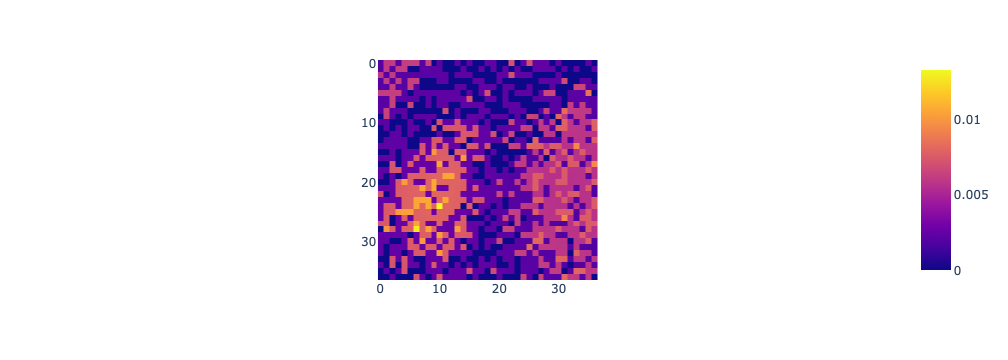

In [178]:
px.imshow(env.get_reward_array())

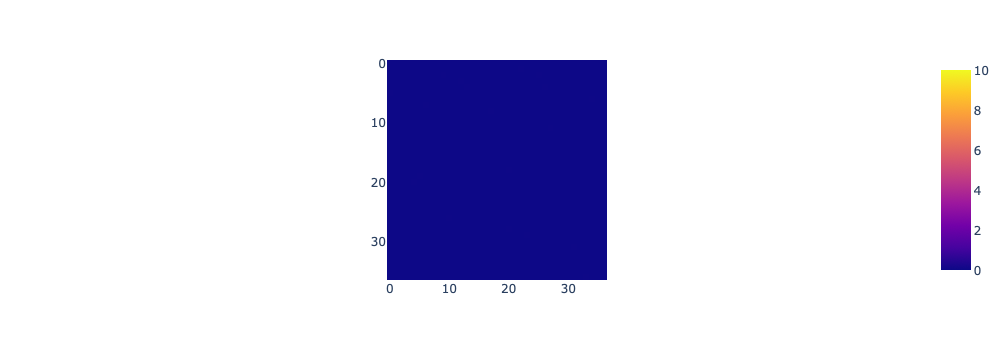

In [190]:
px.imshow(progress_dict['0']['state_value'], zmax=10, zmin=0.0)

In [ ]:
import plotly.graph_objects as go

In [ ]:
matrix_list = [progress_dict[x]['state_value'] for x in progress_dict.keys()]

In [ ]:
fig = go.Figure(
    data=[go.Heatmap(z=matrix_list[0])],
    layout=go.Layout(
        title="Frame 0",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None]),
                    dict(label="Pause",
                         method="animate",
                         args=[None,
                               {"frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}}],
                         )])]
    ),
    frames=[go.Frame(data=[go.Heatmap(z=matrix_list[i])], layout=go.Layout(title_text=f"Frame {i}")) for i in range(1, len(matrix_list))]
)

fig.show()

----
----

In [ ]:
# Request codes
MOTOR_CONTROL = 1000
STATE_REQUEST = 2000
RESET_CODE = 6666

def scan_space(arduino):
    # Run start
    run_start = time.time()
    data_dict_list = []
    last_motor_interval = 0
    last_measure_interval = -1
    motor_frequency = 2
    measure_frequency = 1
    # Set timeouts
    abort = False
    
    for xy_degree in range(0, 181, 5):
        for yz_degree in range(0, 181, 5):
            si.write_serial_line(arduino, [MOTOR_CONTROL, xy_degree, yz_degree], print_message=False)
            new_message, abort = si.listen_for_serial(arduino)
            if new_message is not None and not abort:
                data_dict_list.append(new_message)
            elif abort:
                break
            else:
                print('Empty message received without abort issue')
            time.sleep(0.1) # Wait for steady state
        if abort:
            break
        print('xy:',xy_degree,'yz:',yz_degree)
    # Write back to start state
    write_serial_line(arduino, [si.MOTOR_CONTROL, 90, 90])

    return pd.DataFrame(data_dict_list)

In [ ]:
if __name__ == '__main__':
    print('\nARDUINO CONTROL TESTING')
    print('-------------------------')
    # Initialize serial port
    print('\nIniitalizing device...')
    serial_port = '/dev/cu.usbmodem14101'
    baud_rate = 9600
    timeout = 5
    arduino = si.initialize_serial(serial_port=serial_port, baud_rate=baud_rate, timeout=timeout)
    print('\t - SUCCESS: Device initialized.')
    
    si.write_serial_line(arduino, [MOTOR_CONTROL, 90, 90])

    # Run a loop where motor position incremented every 5 seconds, print out message
    print('\nBeginning loop sequence...')
#     data = scan_space(arduino)
    print('\t - Loop complete.')

    # Add relative time to returned data and print out
#     data['t_relative'] = data['timestamp'] - data['timestamp'].iloc[0]
    print('\nData broadcasted by Arduino:\n')
    
#     data.to_csv('/Users/jackogrady/Git/rl-solar/rl_agent/simulation_data/data/run_6_kitchen_no_lights_swapped_motors.csv', index=False)

In [ ]:
print(data)

In [ ]:
write_serial_line(arduino, [1000, 180, 90])